In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../Data/train.csv')

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

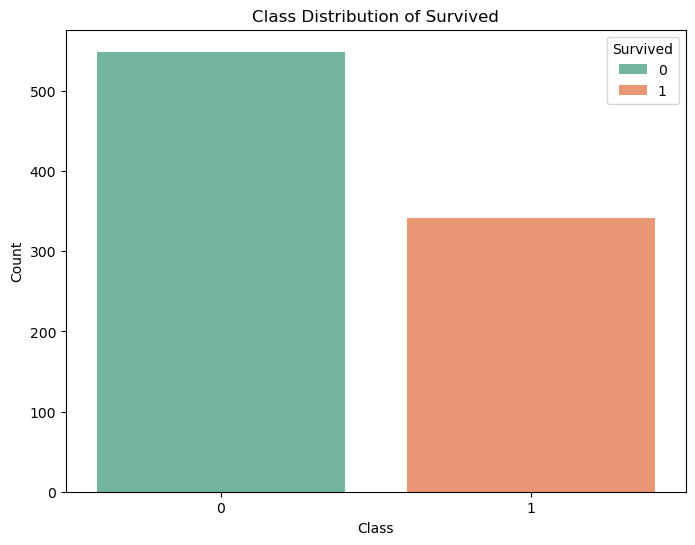

In [10]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Survived', data=df, palette='Set2',hue='Survived')
plt.title(f'Class Distribution of Survived')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [11]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [12]:
df_drop = df.drop('Cabin',axis=1)

In [13]:
df_drop[df_drop['Age'].isna()].Survived.value_counts()

Survived
0    125
1     52
Name: count, dtype: int64

In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [15]:
def encode(df):
    label_encoders = {}
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str)) 
        label_encoders[col] = le
    return df, label_encoders

def impute(df, n_neighbors=5):
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    print(f"\n--- Imputed Data using KNN with {n_neighbors} neighbors ---")
    df_imputed['Survived'] = df_imputed['Survived'].astype(int)
    return df_imputed

def scale(df, target):
    scaler = StandardScaler()
    y = df[target]
    x = df.drop(target,axis=1)
    numerical_cols = x.select_dtypes(include=['float64', 'int64']).columns
    x[numerical_cols] = scaler.fit_transform(x[numerical_cols])
    print("\n--- Scaled Numerical Columns using StandardScaler ---")
    return pd.concat([x,y],axis=1)

In [16]:
df_encoded, encoder = encode(df)

In [17]:
df_imputed = impute(df_encoded)


--- Imputed Data using KNN with 5 neighbors ---


In [18]:
df_imputed.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [19]:
df_scaled = scale(df_imputed, 'Survived')


--- Scaled Numerical Columns using StandardScaler ---


In [20]:
X = df_scaled.drop('Survived',axis=1)
y = df_scaled['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Apply SMOTE for oversampling the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [22]:
y_test.value_counts()

Survived
0    105
1     74
Name: count, dtype: int64

In [23]:
from lightgbm import LGBMClassifier

In [24]:
model = LGBMClassifier()
model.fit(X_train_resampled,y_train_resampled)

[LightGBM] [Info] Number of positive: 444, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1412
[LightGBM] [Info] Number of data points in the train set: 888, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier()

In [25]:
from sklearn.metrics import classification_report
import json

In [26]:
predict = model.predict(X_test)

In [28]:
report = classification_report(y_test,predict, output_dict=True)
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       105
           1       0.79      0.73      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



In [29]:
with open('classification_report.json','w') as f:
    json.dump(report,f)

In [30]:
import pickle

In [31]:
with open('model.pkl', 'wb') as f:
    pickle.dump(model,f)

In [32]:
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

In [33]:
model

LGBMClassifier()